<a href="https://colab.research.google.com/github/SaiPavanKumarB/Liberty-Insurance-Case-Study/blob/main/Liberty_Insurance_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="black" face="Arial" size=6><center> Liberty Insurance - Case Study </center></font>


---



# Motor Insurance Claims

> Purpose of this case study is to analyze the historical data of motor insurance claims by customers & build a model that predicts the number of claims during the time frame of policy





## DATA DESCRIPTION:


*   **policy_desc**: Policy Identifier; Primary Key which is unique for every policy
*   **claim_count**: Total Claims (This is the response you should predicting); Numeric Variable
*   **cat_areacode**: Area Code; Categorical Variable
*   **num_vehicleAge**: Age of the vehicle; Numeric Variable
*   **num_noClaimDiscountPercent**: Percentage of discount applied to policy premium based on claim history. If value is greater than 100 then policy premium was increased, if it’s less than 100 a discount was applied. A value of 100 means the premium remain unchanged; Numerical Variable
*   **cat_carBrand**: Insured Vehicle Brand; Categorical Variable
*   **num_populationDensitykmsq**: Population density of the city the policy holder lives in; Numerical Variable
*   **cat_Region**: Region of the country the policy holder lives in; Categorical Variable
*   **ord_vehicleHP**: Vehicle Horsepower; This feature is anonymised but maintains the same ordinality; Ordinal Variable
*   **num_exposure**: Exposure time of policy. Time period within which the claims were made; Numerical Variable
*   **cat_fuelType**: Insured Vehicle Fuel Type; Categorical Variable
*  **num_driverAge**: Age of the Policy Holder; Numerical Variable













*The text file is huge as it contains about 678014 rows *





## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_palette('tab10')
sns.set_style('darkgrid')

from google.colab import files
import io
import warnings
import re
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer
from scipy.stats import f_oneway,chi2_contingency,chi2
from imblearn.over_sampling import SMOTENC,SMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,recall_score,classification_report,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier


## Read Input Data File

In [2]:
Input_df = pd.read_csv('casestudy_data.csv')
print("Shape of the data:{}".format(Input_df.shape))
Input_df.head()


Shape of the data:(678013, 12)


,policy_desc,claim_count,cat_areacode,num_vehicleAge,num_noClaimDiscountPercent,cat_carBrand,num_populationDensitykmsq,cat_Region,ord_vehicleHP,num_exposure,cat_fuelType,num_driverAge
0,1,1,D,0,50,B12,1217,R82,5,0.1,Regular,55
1,3,1,D,0,50,B12,1217,R82,5,0.77,Regular,55
2,5,1,B,2,50,B12,54,R22,6,0.75,Diesel,52
3,10,1,B,0,50,B12,76,R72,7,0.09,Diesel,46
4,11,1,B,0,50,B12,76,R72,7,0.84,Diesel,46


### Check Data types & Missing Values

In [3]:
Input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   policy_desc                 678013 non-null  int64 
 1   claim_count                 678013 non-null  int64 
 2   cat_areacode                678013 non-null  object
 3   num_vehicleAge              678013 non-null  int64 
 4   num_noClaimDiscountPercent  678013 non-null  int64 
 5   cat_carBrand                678013 non-null  object
 6   num_populationDensitykmsq   678013 non-null  int64 
 7   cat_Region                  678013 non-null  object
 8   ord_vehicleHP               678013 non-null  int64 
 9   num_exposure                678013 non-null  object
 10  cat_fuelType                677991 non-null  object
 11  num_driverAge               677999 non-null  object
dtypes: int64(6), object(6)
memory usage: 62.1+ MB


In [4]:
Input_df.isna().sum()

policy_desc                    0
claim_count                    0
cat_areacode                   0
num_vehicleAge                 0
num_noClaimDiscountPercent     0
cat_carBrand                   0
num_populationDensitykmsq      0
cat_Region                     0
ord_vehicleHP                  0
num_exposure                   0
cat_fuelType                  22
num_driverAge                 14
dtype: int64

Fuel Type has 22 missing values & Driver age has 14 missing values.
Ignore these records given the number compared to the overall records

In [5]:
Input_df.dropna(inplace=True)
print(Input_df.shape)

(677977, 12)


## Check Distribution Of Target Variable

0     643919
1      32176
2       1784
3         82
4          7
11         3
5          2
16         1
9          1
8          1
6          1
Name: claim_count, dtype: int64


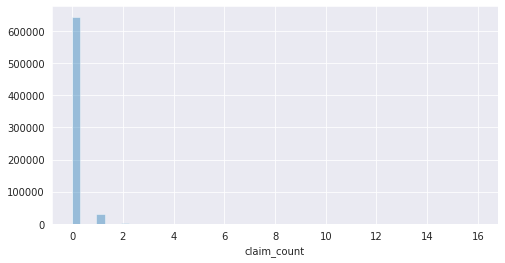

In [6]:
plt.figure(figsize=(8,4))
sns.distplot(Input_df['claim_count'],kde=False)
print(Input_df['claim_count'].value_counts())

The distribution is skewed & not a decent spread. 

## Converting Target Variable into Buckets


> Given the distribution of the target variable, we will split the target into 3 buckets
1.   No_Claims
2.   1_Claim
1.   2_Or_More_Claims

This converts the problem into a Multi-Class Classification with Imbalance

*Create a copy of the dataset to workupon, retaining the original dataframe as is*





In [7]:
Data_copy_df = Input_df.copy()

Data_copy_df['Num_of_Claims'] = np.where(Data_copy_df['claim_count']==0,'No_Claims',
                                         np.where(Data_copy_df['claim_count']==1,'1_Claim',
                                         '2_Or_More_Claims')
                                         )
print(Data_copy_df['Num_of_Claims'].value_counts())

No_Claims           643919
1_Claim              32176
2_Or_More_Claims      1882
Name: Num_of_Claims, dtype: int64


Now we have 4 target classes



---



In [8]:
Data_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677977 entries, 0 to 678012
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   policy_desc                 677977 non-null  int64 
 1   claim_count                 677977 non-null  int64 
 2   cat_areacode                677977 non-null  object
 3   num_vehicleAge              677977 non-null  int64 
 4   num_noClaimDiscountPercent  677977 non-null  int64 
 5   cat_carBrand                677977 non-null  object
 6   num_populationDensitykmsq   677977 non-null  int64 
 7   cat_Region                  677977 non-null  object
 8   ord_vehicleHP               677977 non-null  int64 
 9   num_exposure                677977 non-null  object
 10  cat_fuelType                677977 non-null  object
 11  num_driverAge               677977 non-null  object
 12  Num_of_Claims               677977 non-null  object
dtypes: int64(6), object(7)
memory

## Check Values in Each Column
#### Exposure & Driver Age Col names states that to be numeric, but data type is object. Check for any inconsistency in values

#### Exposure Column

In [9]:
Data_copy_df.loc[Data_copy_df['num_exposure'].apply(lambda x: x.isalnum())]['num_exposure'].value_counts()

1          168101
37years        27
23years        27
10years        17
2               1
Name: num_exposure, dtype: int64

Exposure column, though should contain numeric data as per naming convention, seems to contain data entry issues like above. For example, 37 is entered as 37 years. There are about 168173 rows with such issues. Rest of the values are float. 
To bring consistency, let's convert this to float column

In [10]:
def fun_fix_Exposure(x):
  if x.isalnum():
    res = re.findall(r"\d+",x)[0]
  else:
    res=x
  return res

In [11]:
Data_copy_df['num_exposure'] = Data_copy_df['num_exposure'].apply(fun_fix_Exposure)

#### Driver Age Column


In [12]:
Data_copy_df.loc[Data_copy_df['num_driverAge'].apply(lambda x: not str(x).isdigit())]['num_driverAge']

258         
105969      
165364      
212991      
217702      
          ..
624661      
624718      
635940      
650714      
676421      
Name: num_driverAge, Length: 65554, dtype: object

Driver Age column contains blank values for about 65000 records. This is again missing values that needs to be treated

In [13]:
def fun_fix_DriverAge(x):
  if not str(x).isdigit():
    res = np.nan
  else:
    res=x
  return res

In [14]:
Data_copy_df['num_driverAge'] = Data_copy_df['num_driverAge'].apply(fun_fix_DriverAge)

In [15]:
Data_copy_df.isna().sum()

policy_desc                       0
claim_count                       0
cat_areacode                      0
num_vehicleAge                    0
num_noClaimDiscountPercent        0
cat_carBrand                      0
num_populationDensitykmsq         0
cat_Region                        0
ord_vehicleHP                     0
num_exposure                      0
cat_fuelType                      0
num_driverAge                 65554
Num_of_Claims                     0
dtype: int64

DriverAge column has 65554 missing values, which we will fix at later stage using KNNImputer

In [16]:
Data_copy_df['ord_vehicleHP'] = Data_copy_df['ord_vehicleHP'].astype('object')
Data_copy_df['num_exposure'] = Data_copy_df['num_exposure'].astype('float64')
Data_copy_df['num_driverAge'] = Data_copy_df['num_driverAge'].astype('float64')

## Rename columns

Rename columns for better readability & understanding

In [17]:
Col_names = {'num_vehicleAge':'Vehicle_Age','num_noClaimDiscountPercent':'No_Claim_Discount_Perc','num_populationDensitykmsq':'Population_Density_KmSq',
             'cat_areacode':'Area_Code','cat_carBrand':'Car_Brand','ord_vehicleHP':'Vehicle_HP','num_exposure':'Policy_Exposure_Time',
             'cat_fuelType':'Fuel_Type','num_driverAge':'Driver_Age'}
Data_copy_df.rename(Col_names,axis=1,inplace=True)
Data_copy_df.head()

,policy_desc,claim_count,Area_Code,Vehicle_Age,No_Claim_Discount_Perc,Car_Brand,Population_Density_KmSq,cat_Region,Vehicle_HP,Policy_Exposure_Time,Fuel_Type,Driver_Age,Num_of_Claims
0,1,1,D,0,50,B12,1217,R82,5,0.10,Regular,55.0,1_Claim
1,3,1,D,0,50,B12,1217,R82,5,0.77,Regular,55.0,1_Claim
2,5,1,B,2,50,B12,54,R22,6,0.75,Diesel,52.0,1_Claim
3,10,1,B,0,50,B12,76,R72,7,0.09,Diesel,46.0,1_Claim
4,11,1,B,0,50,B12,76,R72,7,0.84,Diesel,46.0,1_Claim


Get list of numeric & categorical columns

In [18]:
Num_cols = []
Cat_Cols = []
for i in Data_copy_df.columns:
  if (Data_copy_df[i].dtype!='O'):
    Num_cols.append(i)
  elif (Data_copy_df[i].dtype=='O'):
    Cat_Cols.append(i)
  else :
    print("Data Type for column {} undefined".format(i))

Num_cols.remove('policy_desc')
Num_cols.remove('claim_count')
print("Numeric Columns : ",Num_cols)
print("Categorical Columns: ",Cat_Cols)

Numeric Columns :  ['Vehicle_Age', 'No_Claim_Discount_Perc', 'Population_Density_KmSq', 'Policy_Exposure_Time', 'Driver_Age']
Categorical Columns:  ['Area_Code', 'Car_Brand', 'cat_Region', 'Vehicle_HP', 'Fuel_Type', 'Num_of_Claims']


## Visual Inspection of Data

### Numeric Columns

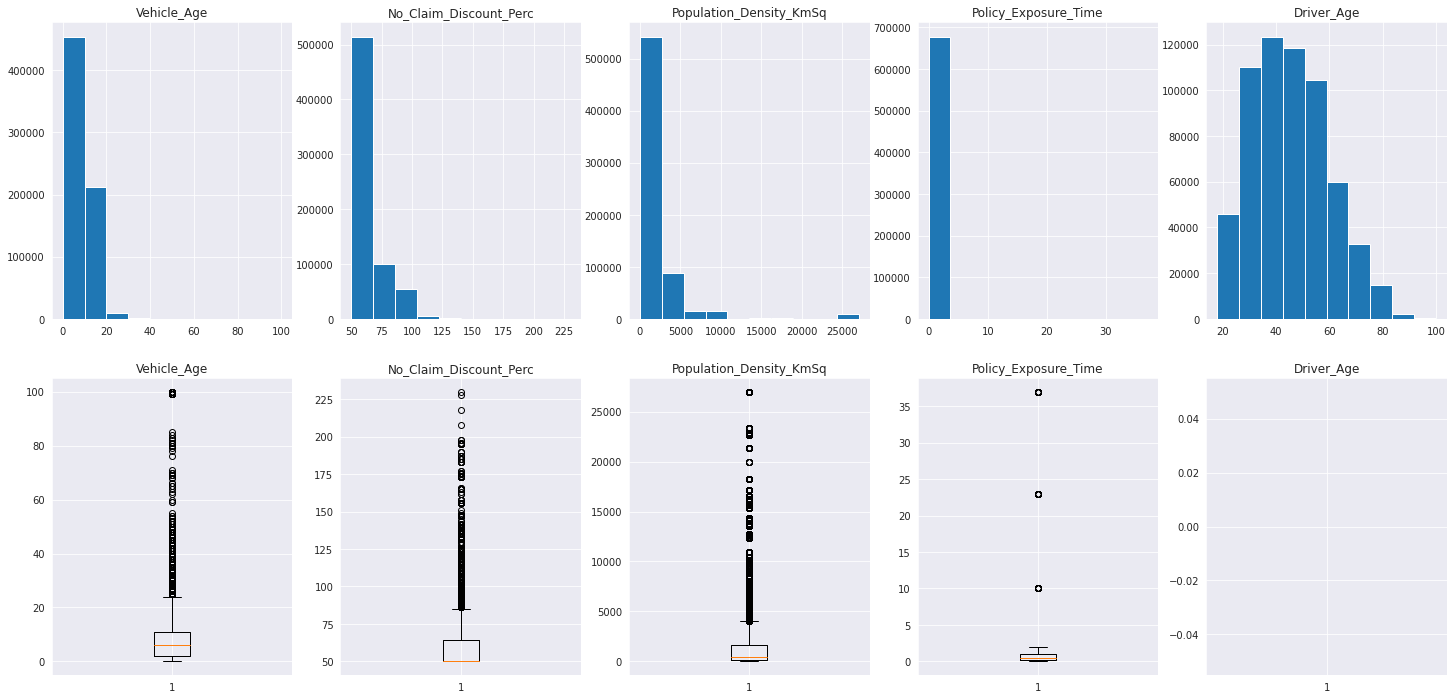

In [19]:
fig, ax = plt.subplots(nrows=2,ncols=len(Num_cols),figsize=(25,12))

for i,col_name in enumerate(Num_cols):
  ax[0,i].hist(Data_copy_df[col_name])
  ax[0,i].title.set_text(col_name)
  ax[1,i].boxplot(Data_copy_df[col_name])
  ax[1,i].title.set_text(col_name)


Except for Driver Age, rest of the numeric columns are skewed.
Also, 3 extreme outliers for Policy Exposure Time. Policies that are more than 10 years. Need to verify the authenticity of it.

### Numeric Columns w.r.t Target Column

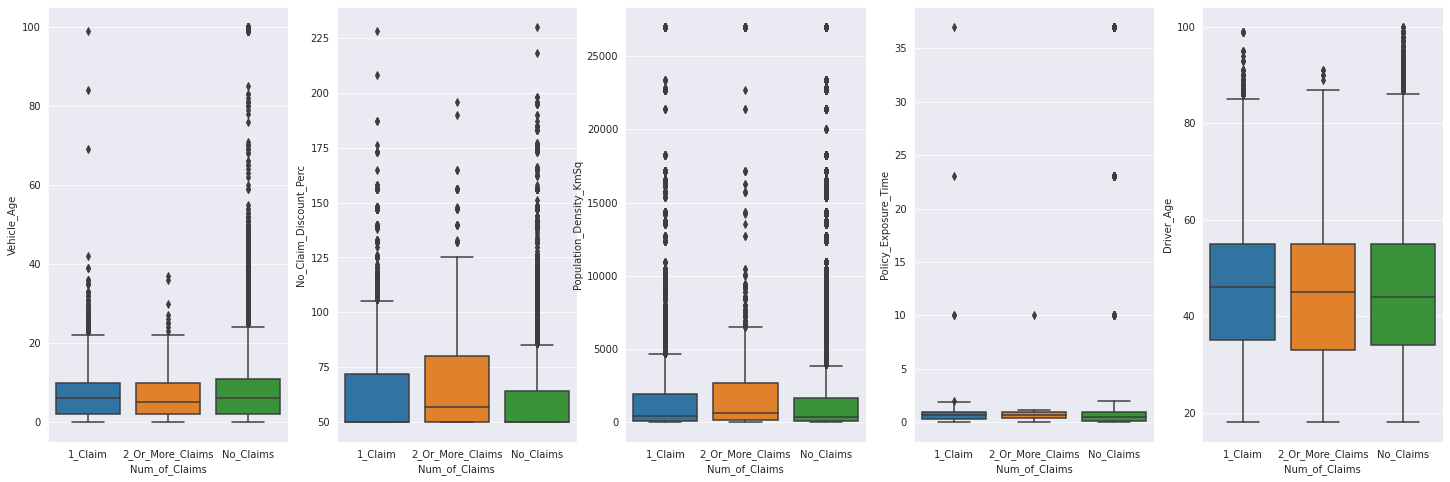

In [20]:
fig,ax = plt.subplots(1,len(Num_cols),figsize=(25,8))
for i,col_name in enumerate(Num_cols):
  sns.boxplot(x="Num_of_Claims",y=col_name,data=Data_copy_df,ax=ax[i])



*   There are quite a good number of points where vehicle age is more than 60, which in reality is bit difficult to believe.
*   Likewise, certain rows seem to have Person age more than 90 or close to 100, which is again dependent on the actual scenario.
*   There are few points with exposure time more than 10,25 & 30. If the unit of the exposure time is years, then these data points needs to be validated for facts.
*   Quite a good amount of outliers in each of the categories




*   Clearly evident from the distributions in No Claims Discount Percent i.e. spread is more as claims increase. However, there are certain rows who haven't made a claim yet paid more than actual premium price i.e. more than 100%. These outlier numbers are more high in no claim category as compared to any other category. Let's remove these rows as well.
*   Population density seems to have some impact on the claims.



In [21]:
Data_copy_df[(Data_copy_df['Vehicle_Age']>=40) | (Data_copy_df['Driver_Age']>=80) | (Data_copy_df['Policy_Exposure_Time']>=10)].shape

(7866, 13)

In [22]:
Data_copy_df[(Data_copy_df['Num_of_Claims']=='No_Claims') & (Data_copy_df['No_Claim_Discount_Perc']>=125)].shape

(1816, 13)

7866 + 1809 =  9675 rows will be removed through these conditions

In [23]:
index_vals = Data_copy_df[(Data_copy_df['Vehicle_Age']>=40) | (Data_copy_df['Driver_Age']>=80) | (Data_copy_df['Policy_Exposure_Time']>=10)].index
Data_copy_df.drop(index=index_vals,inplace=True)

index_vals = Data_copy_df[(Data_copy_df['Num_of_Claims']=='No_Claims') & (Data_copy_df['No_Claim_Discount_Perc']>=125)].index
Data_copy_df.drop(index=index_vals,inplace=True)
print(Data_copy_df.shape)

(668302, 13)


Check the distributions again

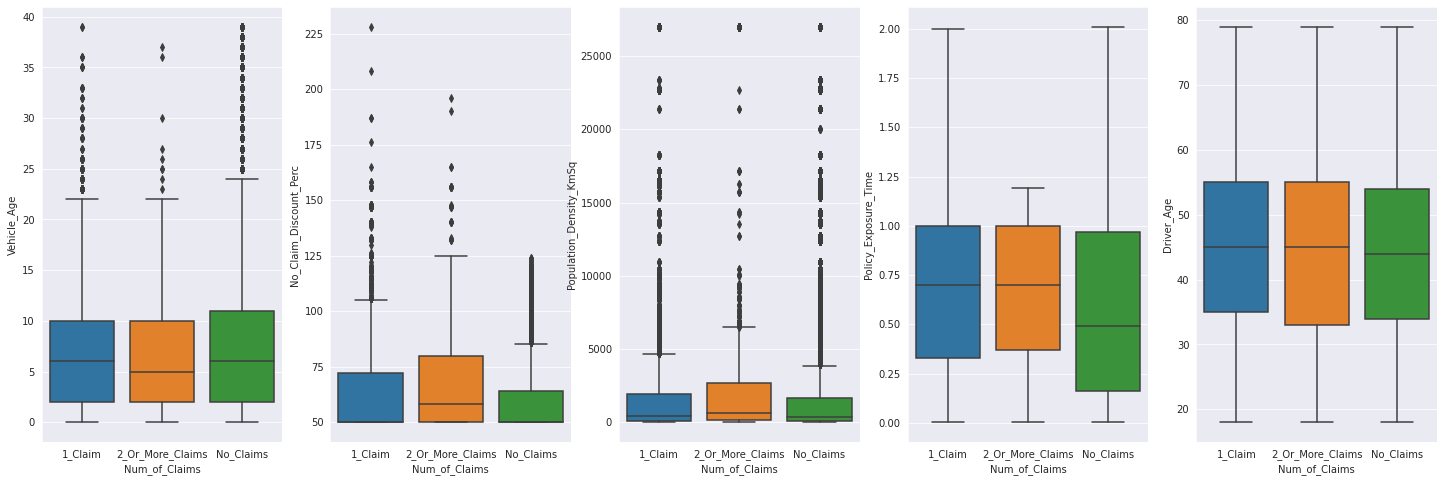

In [24]:
fig,ax = plt.subplots(1,len(Num_cols),figsize=(25,8))
for i,col_name in enumerate(Num_cols):
  sns.boxplot(x="Num_of_Claims",y=col_name,data=Data_copy_df,ax=ax[i])

### Categorical Columns

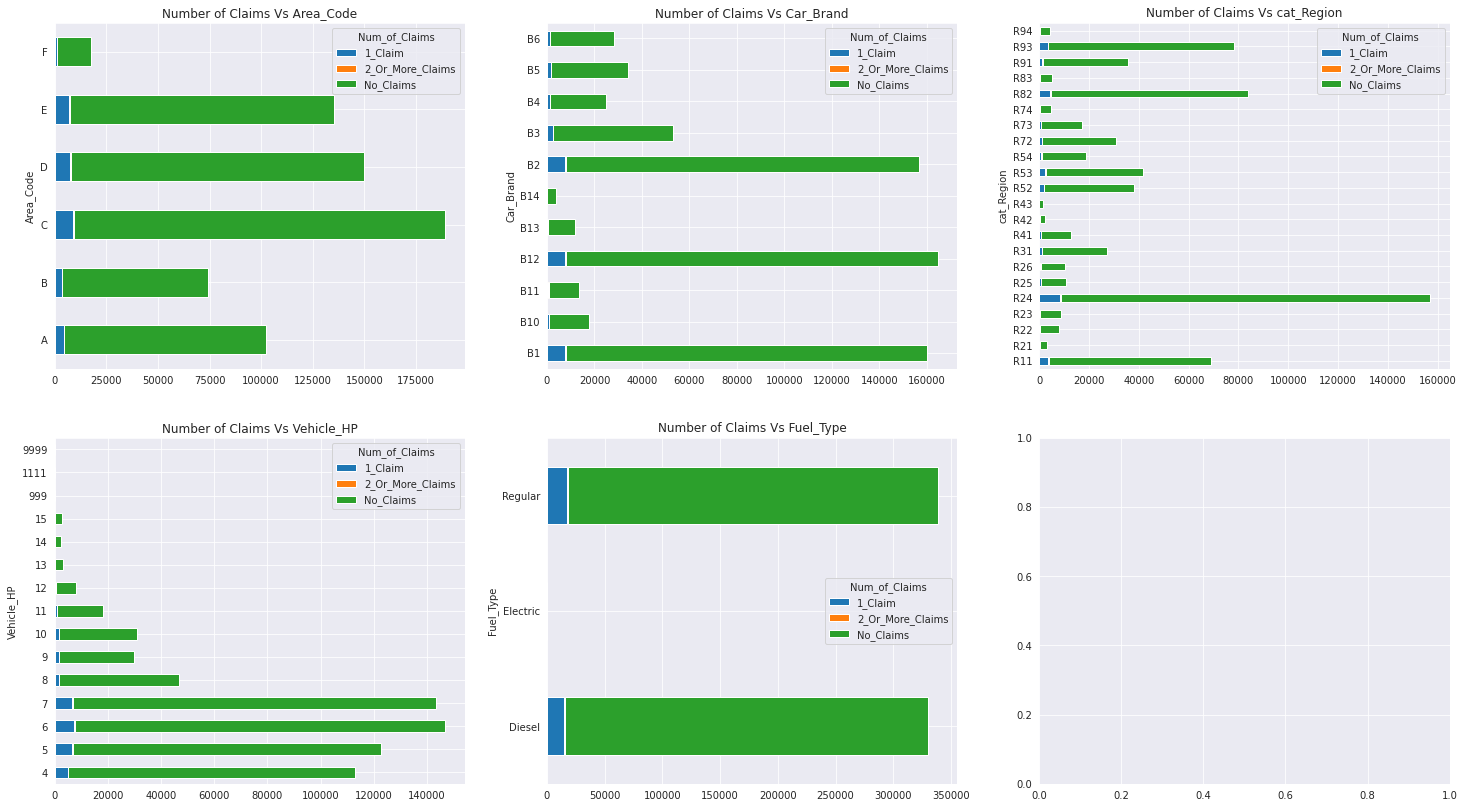

In [25]:
fig,ax = plt.subplots(2,3,figsize=(25,14))

r=0
for i ,colname in enumerate(Cat_Cols):
  df = pd.crosstab(Data_copy_df[colname],
            Data_copy_df['Num_of_Claims'])
  df.reset_index(inplace=True)
  title = 'Number of Claims Vs '+colname
  if i>=3:
    r=1
    i-=3
  if colname == 'Num_of_Claims':
    continue
  df.plot(x=colname, kind='barh',stacked=True, title=title,ax=ax[r,i])



*   Areas C,D,E (in the same order) have significant number of claims i.e. atleast 1 claim than other area codes.
*   Lower Horse Power have atleast 1 claim as compared to higher HP vehicles
*   B11,B13,B14 have no claims (though they are less policies for that brand) so far.
*   Few regions dont have any claims at all, while R24 leads policies having atleast 1 claim.

However, given the huge inequal distribution, data about 2_or_More_Claims isn't evident when clubbed with other categories. Let's seperate that data to see how it fares among each of the categorical variables





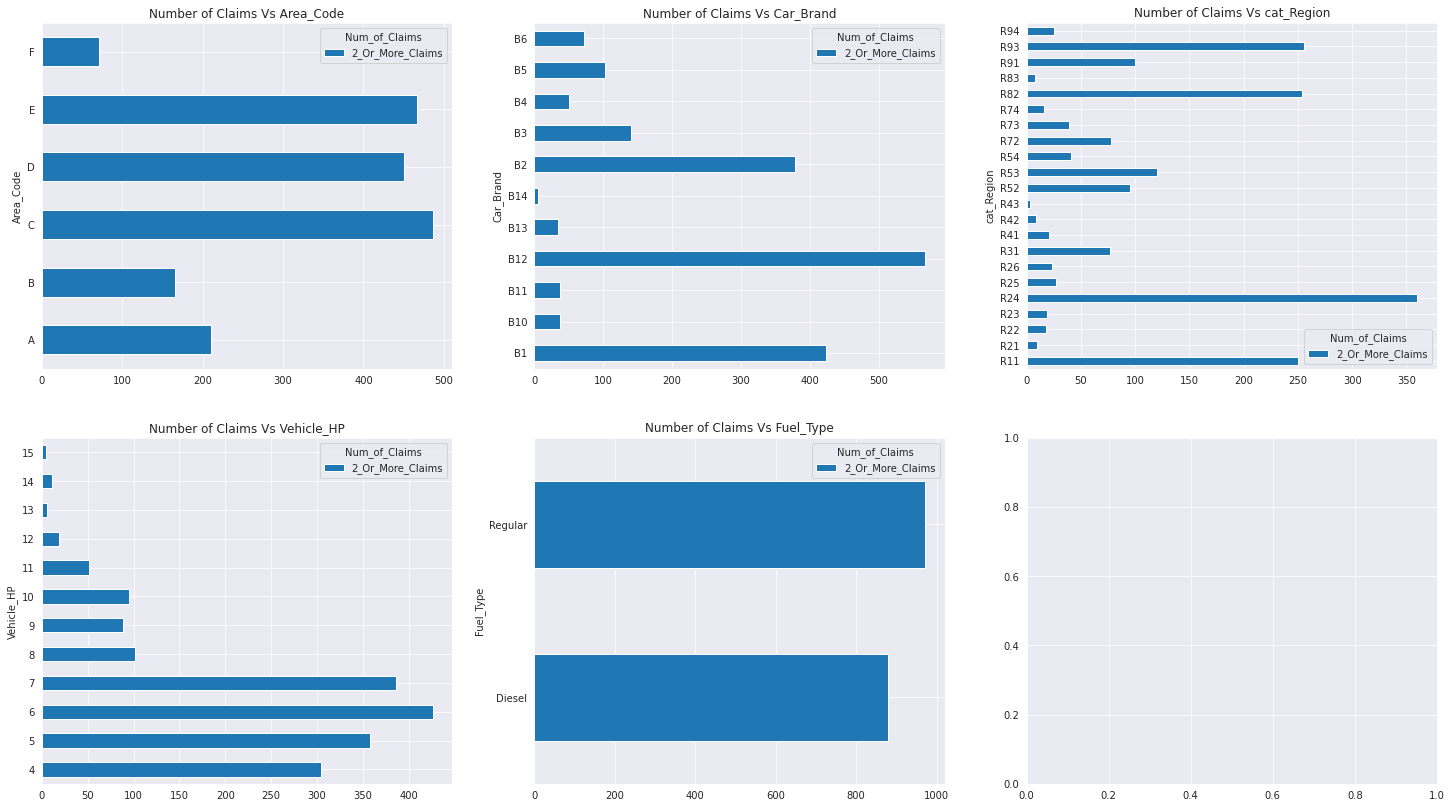

In [26]:
df1 = Data_copy_df[Data_copy_df.Num_of_Claims=='2_Or_More_Claims']

fig,ax = plt.subplots(2,3,figsize=(25,14))

r=0
for i ,colname in enumerate(Cat_Cols):
  df = pd.crosstab(df1[colname],
            df1['Num_of_Claims'])
  df.reset_index(inplace=True)
  title = 'Number of Claims Vs '+colname
  if i>=3:
    r=1
    i-=3
  if colname == 'Num_of_Claims':
    continue
  df.plot(x=colname, kind='barh',stacked=True, title=title,ax=ax[r,i])

More or less same trend seems to be appearing in most of the categorical variables.

## Few More Observations

### Any link between Car Brand & Area

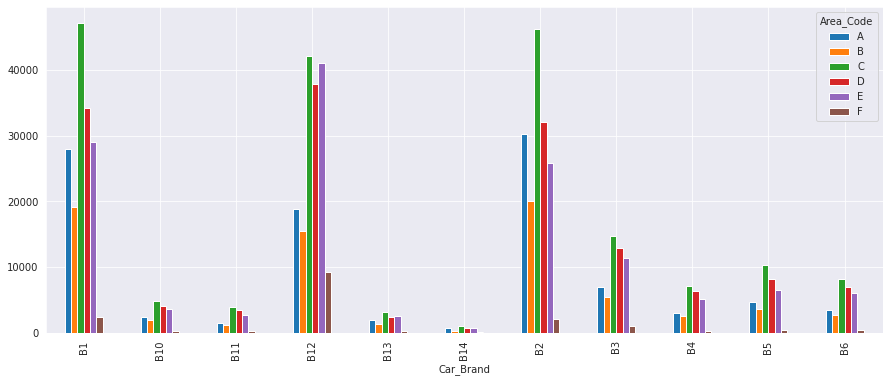

In [27]:
df = pd.crosstab(Data_copy_df['Car_Brand'],
                 Data_copy_df['Area_Code'])
df.reset_index(inplace=True)
df.plot(kind='bar',x='Car_Brand',figsize=(15,6))

All car brands are used in all areas

### Any relation between Area & Region Code

In [28]:
Data_copy_df.columns

Index(['policy_desc', 'claim_count', 'Area_Code', 'Vehicle_Age',
       'No_Claim_Discount_Perc', 'Car_Brand', 'Population_Density_KmSq',
       'cat_Region', 'Vehicle_HP', 'Policy_Exposure_Time', 'Fuel_Type',
       'Driver_Age', 'Num_of_Claims'],
      dtype='object')

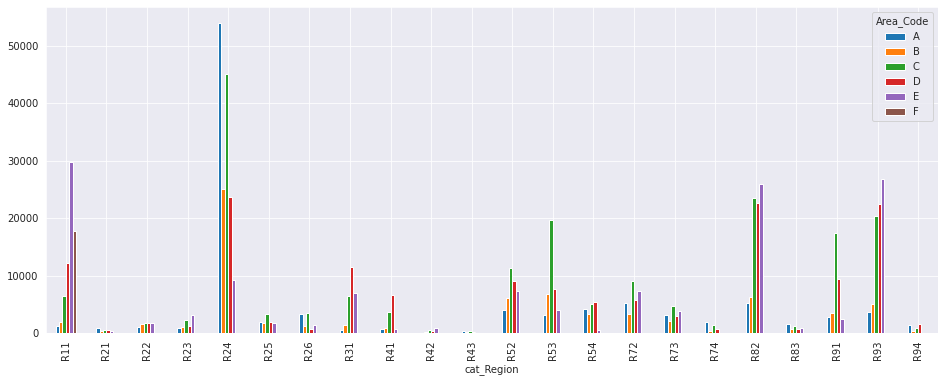

In [29]:
df = pd.crosstab(Data_copy_df['cat_Region'],Data_copy_df['Area_Code'])
df.reset_index(inplace=True)
df.plot(kind='bar',x='cat_Region',figsize=(16,6))

Each Area has almost all the region types. No region is particular to a particular area

### Which Fuel Type vehicle is popular in an Area

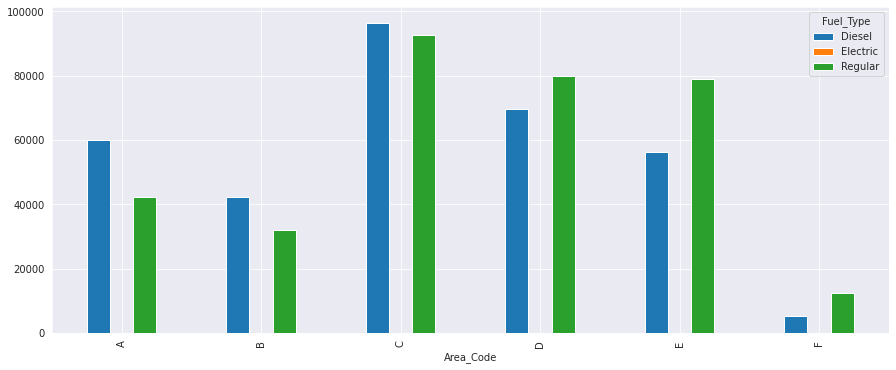

In [30]:
df=pd.crosstab(Data_copy_df['Area_Code'],Data_copy_df['Fuel_Type'])
df.reset_index(inplace=True)
df.plot(x='Area_Code',kind='bar',figsize=(15,6))

### Check Data for Electric Vehicles & Vehicle with HP 999,99

In [31]:
Data_copy_df[Data_copy_df['Fuel_Type']=='Electric'].shape

(15, 13)

Only 15 vehicle policies

In [32]:
Data_copy_df[(Data_copy_df['Vehicle_HP']==9999) | (Data_copy_df['Vehicle_HP']==1111) | (Data_copy_df['Vehicle_HP']==999)].shape

(80, 13)

Only 80 rows with vehicles of this HP.

In [33]:
Data_copy_df.columns

Index(['policy_desc', 'claim_count', 'Area_Code', 'Vehicle_Age',
       'No_Claim_Discount_Perc', 'Car_Brand', 'Population_Density_KmSq',
       'cat_Region', 'Vehicle_HP', 'Policy_Exposure_Time', 'Fuel_Type',
       'Driver_Age', 'Num_of_Claims'],
      dtype='object')

## Perform Statistical Tests

In [34]:
Target = 'Num_of_Claims'
Features_to_Consider = []

print('Numeric Columns')
print('*'*30)
for col in Num_cols:
  stat,p_value = f_oneway(Data_copy_df[Data_copy_df[Target]=='No_Claims'][col],
                          Data_copy_df[Data_copy_df[Target]=='1_Claim'][col],
                          Data_copy_df[Data_copy_df[Target]=='2_Or_More_Claims'][col])
  if p_value <= 0.05:
    print('Col {} can be considered as feature'.format(col))
    Features_to_Consider.append(col)

for col in Cat_Cols:
  if col == Target:
    continue;
  df=pd.crosstab(Data_copy_df['Num_of_Claims'],Data_copy_df[col])
  stat, p, dof, expected = chi2_contingency(df)
  prob = 0.95
  critical = chi2.ppf(prob, dof)
  if abs(stat) >= critical:
    print('Col {} can be considered as feature'.format(col))
    Features_to_Consider.append(col)
  else:
	  print('Col {} can not be considered as feature'.format(col))


Numeric Columns
******************************
Col Vehicle_Age can be considered as feature
Col No_Claim_Discount_Perc can be considered as feature
Col Population_Density_KmSq can be considered as feature
Col Policy_Exposure_Time can be considered as feature
Col Area_Code can be considered as feature
Col Car_Brand can be considered as feature
Col cat_Region can be considered as feature
Col Vehicle_HP can be considered as feature
Col Fuel_Type can be considered as feature


Seems All columns can be considered as features to start with. Let's start with Random Forest & get the feature importance plot

## Random Forest (To get Feature Importance)
*   Perform SMOTE with Undersampling
*   Use One Hot Encoding





### Convert Age into buckets

In [35]:
Data_copy_df['Vehicle_Age'] = np.where(Data_copy_df['Vehicle_Age']<=5,'Less_Than_5',
                                       np.where(Data_copy_df['Vehicle_Age']<=10,'5_to_10_Age',
                                                np.where(Data_copy_df['Vehicle_Age']<=20,'10_to_20_Age','Above_20_Age')))
Data_copy_df['Vehicle_Age'].astype('category')

0         Less_Than_5
1         Less_Than_5
2         Less_Than_5
3         Less_Than_5
4         Less_Than_5
             ...     
678008    Less_Than_5
678009    Less_Than_5
678010    Less_Than_5
678011    Less_Than_5
678012    5_to_10_Age
Name: Vehicle_Age, Length: 668302, dtype: category
Categories (4, object): ['10_to_20_Age', '5_to_10_Age', 'Above_20_Age', 'Less_Than_5']

In [36]:
Data_copy_df['Driver_Age'] = np.where(Data_copy_df['Driver_Age']<=25,'Young_Driver',
                                      np.where(Data_copy_df['Driver_Age']<=50,'Medium_Aged_Driver',
                                               np.where(Data_copy_df['Driver_Age']<=60,'Old_Aged_Driver','Very_Old_Driver')))
Data_copy_df['No_Claim_Discount_Perc'] = np.where(Data_copy_df['No_Claim_Discount_Perc']<=50,'Excellent_Driver',
                                                  np.where(Data_copy_df['No_Claim_Discount_Perc']<=75,'Good_Driver',
                                                           np.where(Data_copy_df['No_Claim_Discount_Perc']<=100,'Better_Driver','Paid_More_Premium')))
Data_copy_df['Population_Density_KmSq'] = np.where(Data_copy_df['Population_Density_KmSq']<=1000,'Village',
                                                   np.where(Data_copy_df['Population_Density_KmSq']<=3000,'Town',
                                                            np.where(Data_copy_df['Population_Density_KmSq']<=6000,'City','Metro')))

In [37]:
Data_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668302 entries, 0 to 678012
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   policy_desc              668302 non-null  int64  
 1   claim_count              668302 non-null  int64  
 2   Area_Code                668302 non-null  object 
 3   Vehicle_Age              668302 non-null  object 
 4   No_Claim_Discount_Perc   668302 non-null  object 
 5   Car_Brand                668302 non-null  object 
 6   Population_Density_KmSq  668302 non-null  object 
 7   cat_Region               668302 non-null  object 
 8   Vehicle_HP               668302 non-null  object 
 9   Policy_Exposure_Time     668302 non-null  float64
 10  Fuel_Type                668302 non-null  object 
 11  Driver_Age               668302 non-null  object 
 12  Num_of_Claims            668302 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 91.4+ MB


In [39]:
X = Data_copy_df[Features_to_Consider]
y = Data_copy_df[Target]

# Split to train test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123)
print(Counter(y_train))


Cat_Cols = ['Vehicle_Age','Area_Code','Car_Brand','cat_Region','Vehicle_HP','Fuel_Type']
# Perform One Hot Encoding
X_train_dum = pd.get_dummies(X_train)
X_test_dum = pd.get_dummies(X_test)

# Perform  Undersampling & SMOTE
Smote_Obj = SMOTE(sampling_strategy='auto',random_state=123,n_jobs=-1)
X_train_senn,y_train_senn = Smote_Obj.fit_resample(X_train_dum,y_train) 
print('After SMOTE')
print(Counter(y_train_senn))

Rand_Under = RandomUnderSampler(sampling_strategy='auto',random_state=123)
X_train_und,y_train_und = Rand_Under.fit_resample(X_train_senn,y_train_senn)
print('After undersampling')
print(Counter(y_train_und))

Counter({'No_Claims': 444247, '1_Claim': 22264, '2_Or_More_Claims': 1300})
After SMOTE
Counter({'No_Claims': 444247, '1_Claim': 444247, '2_Or_More_Claims': 444247})
After undersampling
Counter({'1_Claim': 444247, '2_Or_More_Claims': 444247, 'No_Claims': 444247})


## Random Forest for Feature Importance

In [40]:
RF_Model = RandomForestClassifier(n_estimators=200,max_depth=8,n_jobs=-1)
RF_Model.fit(X_train_und,y_train_und)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Text(0.5, 0, 'Relative Importance')

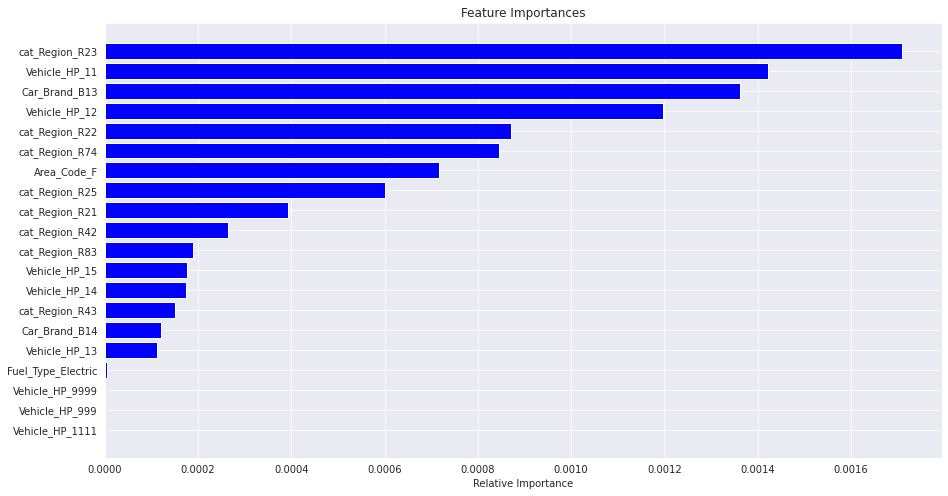

In [41]:
features=X_train_dum.columns
importances = RF_Model.feature_importances_
indices = np.argsort(importances)[:20]

plt.figure(figsize=(15,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

Region, HP, Area, Car Brand seem to be playing major role than any other column

## Random Forest

In [42]:
RF_Model = RandomForestClassifier(n_estimators=300,max_depth=8,n_jobs=-1)
RF_Model.fit(X_train_senn,y_train_senn)

y_pred = RF_Model.predict(X_test_dum)

In [43]:
print('Classification Report')
print(classification_report(y_test,y_pred))

print(confusion_matrix(y_test,y_pred))

Classification Report
                  precision    recall  f1-score   support

         1_Claim       0.07      0.27      0.11      9403
2_Or_More_Claims       0.00      0.28      0.01       549
       No_Claims       0.96      0.67      0.79    190539

        accuracy                           0.65    200491
       macro avg       0.35      0.41      0.30    200491
    weighted avg       0.92      0.65      0.75    200491

[[  2511   2028   4864]
 [   144    156    249]
 [ 32724  30437 127378]]


## Naive Bayes Classifier

In [44]:
Naive_Clf = MultinomialNB()

Naive_Clf.fit(X_train_senn,y_train_senn)

y_pred = Naive_Clf.predict(X_test_dum)
print('Classification Report')
print(classification_report(y_test,y_pred))

print(confusion_matrix(y_test,y_pred))

Classification Report
                  precision    recall  f1-score   support

         1_Claim       0.06      0.34      0.10      9403
2_Or_More_Claims       0.00      0.44      0.01       549
       No_Claims       0.96      0.41      0.57    190539

        accuracy                           0.41    200491
       macro avg       0.34      0.40      0.23    200491
    weighted avg       0.92      0.41      0.55    200491

[[ 3225  3307  2871]
 [  152   244   153]
 [53836 58729 77974]]


Recall is much better here compared to Random Forest

Reduce training data for KNN & SVC

In [45]:
X = Data_copy_df[Features_to_Consider]
y = Data_copy_df[Target]

# Split to train test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123)
print(Counter(y_train))


Cat_Cols = ['Vehicle_Age','Area_Code','Car_Brand','cat_Region','Vehicle_HP','Fuel_Type']
# Perform One Hot Encoding
X_train_dum = pd.get_dummies(X_train)
X_test_dum = pd.get_dummies(X_test)

Rand_Under = RandomUnderSampler(sampling_strategy='auto',random_state=123)
X_train_und,y_train_und = Rand_Under.fit_resample(X_train_dum,y_train)
print('After undersampling')
print(Counter(y_train_und))

Counter({'No_Claims': 444247, '1_Claim': 22264, '2_Or_More_Claims': 1300})
After undersampling
Counter({'1_Claim': 1300, '2_Or_More_Claims': 1300, 'No_Claims': 1300})


## KNN

This requires converting target to numeric & also standardization

In [46]:
y_train_senn_scaled = y_train_und
np.where(y_train_senn_scaled=='No_Claims',0,np.where(y_train_senn_scaled=='1_Claim',1,2))
y_test_scaled = y_test
np.where(y_test_scaled=='No_Claims',0,np.where(y_test_scaled=='1_Claim',1,2))


from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
X_train_senn_scaled = scale.fit_transform(X_train_und)
X_test_scaled = scale.fit_transform(X_test_dum)

KNN_Clf = KNeighborsClassifier(n_jobs=-1,n_neighbors=10,weights='distance')
KNN_Clf.fit(X_train_senn_scaled,y_train_senn_scaled)

y_pred = KNN_Clf.predict(X_test_scaled)
print('Classification Report')
print(classification_report(y_test_scaled,y_pred))

print(confusion_matrix(y_test,y_pred))

Classification Report
                  precision    recall  f1-score   support

         1_Claim       0.05      0.32      0.09      9403
2_Or_More_Claims       0.00      0.37      0.01       549
       No_Claims       0.96      0.41      0.57    190539

        accuracy                           0.40    200491
       macro avg       0.34      0.37      0.22    200491
    weighted avg       0.91      0.40      0.55    200491

[[ 3019  3211  3173]
 [  167   205   177]
 [56904 55736 77899]]


## Support Vector Machines

In [48]:
from sklearn.svm import SVC

SVC_Clf = SVC()
SVC_Clf.fit(X_train_senn_scaled,y_train_senn_scaled)

y_pred = SVC_Clf.predict(X_test_scaled)
print('Classification Report')
print(classification_report(y_test_scaled,y_pred))

print(confusion_matrix(y_test,y_pred))

Classification Report
                  precision    recall  f1-score   support

         1_Claim       0.06      0.26      0.10      9403
2_Or_More_Claims       0.01      0.42      0.01       549
       No_Claims       0.96      0.58      0.72    190539

        accuracy                           0.56    200491
       macro avg       0.34      0.42      0.28    200491
    weighted avg       0.92      0.56      0.69    200491

[[  2482   2894   4027]
 [   122    231    196]
 [ 39168  41491 109880]]


## Further Possible Steps
*   Revisit models with important columns alone
*   Perform StratifiedKFold Cross Validation
*   Hyper Parameter tuning




